In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('NDT_dataset_clean_2.csv', index_col=0)

In [3]:
df['timestamp'] = pd.to_datetime(df['idle_start_time_mdt'], format='mixed')
df['idle_start_hour'] = df['timestamp'].dt.hour

In [4]:
# Select features
features = df[['idle_location_x', 'idle_location_y', 'idle_start_hour', 'idle_duration_hr']]

In [5]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

In [6]:
# Split data
X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)

In [7]:
input_dim = X_train.shape[1]

autoencoder = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(8, activation='relu'),
    layers.Dense(4, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(input_dim, activation='linear')
])

autoencoder.compile(optimizer='adam', loss='mse')

history = autoencoder.fit(
    X_train, X_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, X_test),
    verbose=0
)

In [8]:
# Predict on full data
reconstructions = autoencoder.predict(X_scaled)
reconstruction_error = np.mean((X_scaled - reconstructions) ** 2, axis=1)

# Add error to DataFrame
features['reconstruction_error'] = reconstruction_error

# Set threshold (e.g., top 10% most unusual)
threshold = np.percentile(reconstruction_error, 90)
features['is_natural_downtime'] = features['reconstruction_error'] > threshold

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


C:\Users\omoni\AppData\Local\Temp\ipykernel_35836\2190797830.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['reconstruction_error'] = reconstruction_error
C:\Users\omoni\AppData\Local\Temp\ipykernel_35836\2190797830.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['is_natural_downtime'] = features['reconstruction_error'] > threshold


     idle_location_x  idle_location_y  idle_start_hour  idle_duration_hr  \
85       -1141283033        509446300               18         86.016667   
23       -1141282166        509446499               18         63.108608   
146      -1141283216        509446350               15         41.240836   
219      -1141283633        509446733               13         31.699722   
291      -1141282733        509446800               19         42.687500   

     reconstruction_error  is_natural_downtime  
85               7.505602                 True  
23               3.244953                 True  
146              1.462765                 True  
219              1.091291                 True  
291              1.061731                 True  


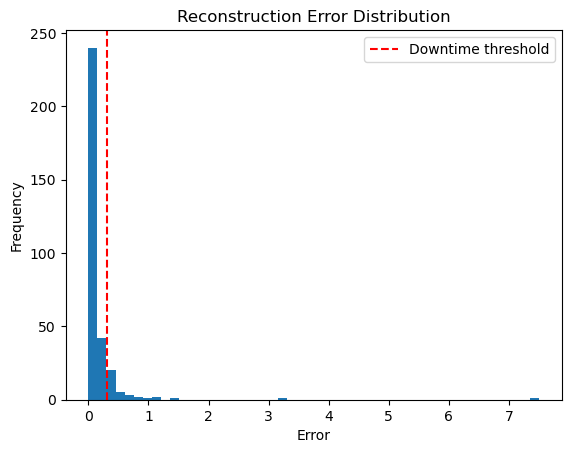

In [9]:
print(features.sort_values('reconstruction_error', ascending=False).head())

plt.hist(features['reconstruction_error'], bins=50)
plt.axvline(threshold, color='red', linestyle='--', label='Downtime threshold')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [10]:
from sklearn.cluster import KMeans

# Use just location features for clustering
location_features = features[['idle_location_x', 'idle_location_y']]

# Optional: scale coordinates for clustering (or skip if already uniform)
scaler = StandardScaler()
location_scaled = scaler.fit_transform(location_features)

# Choose number of clusters (can be tuned with elbow method)
kmeans = KMeans(n_clusters=5, random_state=42)
features['cluster'] = kmeans.fit_predict(location_scaled)

# Get cluster centers in original coordinates (unscaled)
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)

C:\Users\omoni\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\omoni\AppData\Local\Temp\ipykernel_35836\4227181759.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['cluster'] = kmeans.fit_predict(location_scaled)


In [11]:
from pyproj import Transformer

# Adjust this if you know your specific projection
transformer = Transformer.from_crs("epsg:3857", "epsg:4326", always_xy=True)

# Convert idle points
features['lon'], features['lat'] = transformer.transform(features['idle_location_x'].values, features['idle_location_y'].values)

# Convert cluster centers
cluster_lons, cluster_lats = transformer.transform(
    cluster_centers[:, 0], cluster_centers[:, 1]
)


C:\Users\omoni\AppData\Local\Temp\ipykernel_35836\2244057031.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['lon'], features['lat'] = transformer.transform(features['idle_location_x'].values, features['idle_location_y'].values)
C:\Users\omoni\AppData\Local\Temp\ipykernel_35836\2244057031.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['lon'], features['lat'] = transformer.transform(features['idle_location_x'].values, features['idle_location_y'].values)


In [13]:
import folium

# Center map on mean of lat/lon
map_center = [features['lat'].mean(), features['lon'].mean()]
m = folium.Map(location=map_center, zoom_start=12)

# Add idle points colored by cluster
colors = ['red', 'blue', 'green', 'purple', 'orange']

for i, row in features.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=3,
        color=colors[row['cluster'] % len(colors)],
        fill=True,
        fill_opacity=0.6
    ).add_to(m)

# Add cluster center markers
for lat, lon in zip(cluster_lats, cluster_lons):
    folium.Marker(
        location=[lat, lon],
        icon=folium.Icon(color='black', icon='star'),
        popup='Cluster Center'
    ).add_to(m)

m.save('idle_hotspot_map.html')

<function matplotlib.pyplot.show(close=None, block=None)>

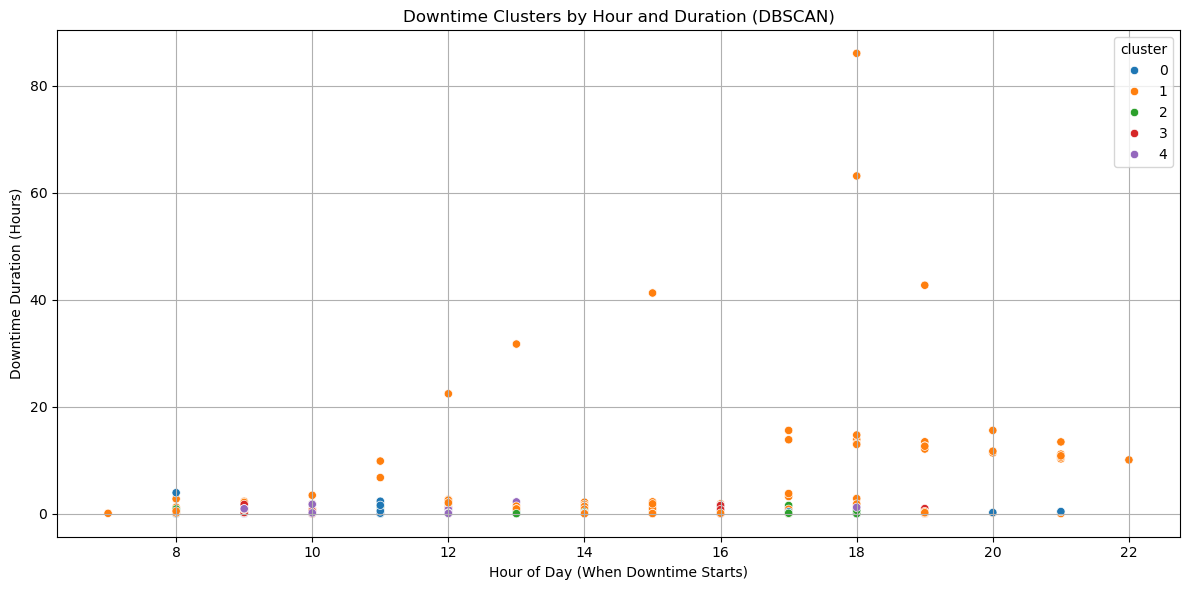

In [15]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=features, 
                x = 'idle_start_hour',
                y = 'idle_duration_hr',
                hue = 'cluster',
                palette = 'tab10')
plt.title('Downtime Clusters by Hour and Duration (DBSCAN)')
plt.xlabel('Hour of Day (When Downtime Starts)')
plt.ylabel('Downtime Duration (Hours)')
plt.grid(True)
plt.tight_layout()
plt.show

In [21]:
# Make sure you have these columns
coords = features[['lat', 'lon']].to_numpy()

In [23]:
from sklearn.cluster import DBSCAN
import numpy as np

# Convert degrees to radians for haversine
coords_rad = np.radians(coords)

# DBSCAN using haversine distance
kms_per_radian = 6371.0088  # Earth's radius
epsilon = 0.5 / kms_per_radian  # 0.5 km neighborhood

db = DBSCAN(eps=epsilon, min_samples=5, metric='haversine').fit(coords_rad)
features['dbscan_cluster'] = db.labels_


C:\Users\omoni\AppData\Local\Temp\ipykernel_35836\1987646759.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['dbscan_cluster'] = db.labels_


In [25]:
print(features['dbscan_cluster'].value_counts())
# -1 means "noise" — points that don’t belong to any cluster


dbscan_cluster
0    318
Name: count, dtype: int64


In [36]:
features['lat'] = features['idle_location_y'] / 1e7
features['lon'] = features['idle_location_x'] / 1e7

C:\Users\omoni\AppData\Local\Temp\ipykernel_35836\849308430.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['lat'] = features['idle_location_y'] / 1e7
C:\Users\omoni\AppData\Local\Temp\ipykernel_35836\849308430.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['lon'] = features['idle_location_x'] / 1e7


In [38]:
import folium

# Color palette for clusters
cluster_colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'cadetblue']
noise_color = 'gray'

# Map centered on average location
m = folium.Map(location=[features['lat'].mean(), features['lon'].mean()], zoom_start=12)

for i, row in features.iterrows():
    color = noise_color if row['dbscan_cluster'] == -1 else cluster_colors[row['dbscan_cluster'] % len(cluster_colors)]
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=3,
        color=color,
        fill=True,
        fill_opacity=0.7,
    ).add_to(m)

m.save("dbscan_idle_hotspots.html")